In [ ]:
import pandas as pd
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import json

In [ ]:
# eng_cze
# eng_deu
# eng_fra
# eng_hin
# eng_per
# eng_ron
# eng_tur

In [ ]:
target_lang = "tur"
filetype = "c4"
target_folder = "silver_data_from_c4_relaxed"

df = pd.read_json(f"alternative_data/c4/{target_lang}_translated_pairs.json")

In [ ]:
def which_words_changed(sent1, sent2):
    if len(sent1.split())!=len(sent2.split()):
        return [1]*len(sent1.split())
    else:
        x = []
        for a, b in zip(sent1.split(), sent2.split()):
            x.append(int(a!=b))
        return x

In [ ]:
final_data = []
sentence_ids = list(set(df["sentence_id"]))
for sentence_id in tqdm(sentence_ids):
    sub_df = df.query(f"sentence_id=={sentence_id}")

    source_sentence = sub_df.query("word_id==-1")["sentence"].iloc[0]
    target_sentence = sub_df.query("word_id==-1")["translated_sentences"].iloc[0]

    ch = defaultdict(list)

    for word_id in range(0, max(sub_df["word_id"])+1):
        elements = sub_df.query(f"word_id=={word_id}").to_dict(orient="records")
        changed_s_sentences = [x["sentence"] for x in elements]
        changed_t_sentences = [x["translated_sentences"] for x in elements]
        for changed_s_sentence, changed_t_sentence in zip(changed_s_sentences, changed_t_sentences):
            changed_words = which_words_changed(target_sentence, changed_t_sentence)
            if len(changed_words)!=sum(changed_words):
                ch[word_id].append(changed_words)
    alignment = []
    for source_word_id in ch:
        temp_alignment = defaultdict(int)
        total = len(ch[source_word_id])
        for one_al in ch[source_word_id]:
            for target_word_id, el in enumerate(one_al):
                if el==1:
                    temp_alignment[(source_word_id, target_word_id)]+=1
        for x in temp_alignment:
            alignment.append({"source_word_id":x[0], "target_word_id":x[1], "freq":temp_alignment[x], "total":total})
            
    
    final_data.append({"source_sentence": source_sentence,
                       "target_sentence": target_sentence,
                       "alignment": alignment,
                       "sentence_id": sentence_id})

## Creating Silver Data

In [ ]:
import os

In [ ]:
en_sentences = df.query("word_id==-1")["sentence"].tolist()
target_sentences = df.query("word_id==-1")["translated_sentences"].tolist()

In [ ]:
os.makedirs(f"{target_folder}/eng_{target_lang}", exist_ok=True)

In [ ]:
source_gold_sentences = []
target_gold_sentences = []
r = []
for el in final_data:
    r.append(len([x for x in el["alignment"] if x["freq"]==x["total"] and x["total"]>1])/len(el["source_sentence"].split()))
    source_gold_sentences.append(el["source_sentence"])
    target_gold_sentences.append(el["target_sentence"])

In [ ]:
import seaborn as sns
sns.histplot(r).set(title="Silver Data Alignment Ratio (Normalized by Word Count)", xlabel="Ratio")

In [ ]:
with open(f"{target_folder}/eng_{target_lang}/gold.json", "w") as f:
    json.dump(final_data, f)

In [ ]:
temp_gold = {}
gold = {}
for idx, x in enumerate(final_data):
    temp_gold[idx] = defaultdict(list)
    multi_keys = set()
    for el in x["alignment"]:
        temp_gold[idx][el["source_word_id"]].append(el["target_word_id"])
        if len(temp_gold[idx][el["source_word_id"]])>1:
            multi_keys.add(el["source_word_id"])
    for el in multi_keys:
        del temp_gold[idx][el]


for idx, x in enumerate(final_data):
    gold[idx] = defaultdict(list)
    for el in x["alignment"]:
        if el["freq"]==el["total"] & el["total"]>3 and el["source_word_id"] in temp_gold[idx] and\
            el["target_word_id"] in temp_gold[idx][el["source_word_id"]]:
            gold[idx][el["source_word_id"]].append(el["target_word_id"])

In [ ]:
empty = 0
with open(f"{target_folder}/eng_{target_lang}/gold.txt", "w") as f, open(f"{target_folder}/eng_{target_lang}/eng_{target_lang}.txt", "w") as fg:
    idx = 0
    for el in gold:
        text = f"{idx}\t"
        found = False
        for sw_id in gold[el]:
            for tw_id in gold[el][sw_id]:
                text+= f"{sw_id}-{tw_id} "
                found = True
        if found:
            f.write(text+"\n")
            fg.write(source_gold_sentences[el]+" ||| "+target_gold_sentences[el]+"\n")
            idx+=1
        else:
            empty+=1

In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import json

100%|██████████| 50000/50000 [5:54:54<00:00,  2.35it/s]       


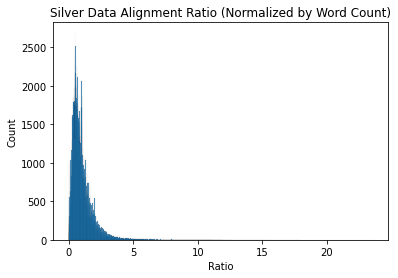

In [2]:
for target_lang in ["cze", "deu", "fra", "ron", "hin", "tur", "per"]:
    filetype = "c4"
    target_folder = "silver_data_from_c4_relaxed"

    df = pd.read_json(f"alternative_data/c4/{target_lang}_translated_pairs.json")

    def which_words_changed(sent1, sent2):
        if len(sent1.split())!=len(sent2.split()):
            return [1]*len(sent1.split())
        else:
            x = []
            for a, b in zip(sent1.split(), sent2.split()):
                x.append(int(a!=b))
            return x

    final_data = []
    sentence_ids = list(set(df["sentence_id"]))
    for sentence_id in tqdm(sentence_ids):
        sub_df = df.query(f"sentence_id=={sentence_id}")

        source_sentence = sub_df.query("word_id==-1")["sentence"].iloc[0]
        target_sentence = sub_df.query("word_id==-1")["translated_sentences"].iloc[0]

        ch = defaultdict(list)

        for word_id in range(0, max(sub_df["word_id"])+1):
            elements = sub_df.query(f"word_id=={word_id}").to_dict(orient="records")
            changed_s_sentences = [x["sentence"] for x in elements]
            changed_t_sentences = [x["translated_sentences"] for x in elements]
            for changed_s_sentence, changed_t_sentence in zip(changed_s_sentences, changed_t_sentences):
                changed_words = which_words_changed(target_sentence, changed_t_sentence)
                if len(changed_words)!=sum(changed_words):
                    ch[word_id].append(changed_words)
        alignment = []
        for source_word_id in ch:
            temp_alignment = defaultdict(int)
            total = len(ch[source_word_id])
            for one_al in ch[source_word_id]:
                for target_word_id, el in enumerate(one_al):
                    if el==1:
                        temp_alignment[(source_word_id, target_word_id)]+=1
            for x in temp_alignment:
                alignment.append({"source_word_id":x[0], "target_word_id":x[1], "freq":temp_alignment[x], "total":total})


        final_data.append({"source_sentence": source_sentence,
                           "target_sentence": target_sentence,
                           "alignment": alignment,
                           "sentence_id": sentence_id})

    ## Creating Silver Data

    import os

    en_sentences = df.query("word_id==-1")["sentence"].tolist()
    target_sentences = df.query("word_id==-1")["translated_sentences"].tolist()

    os.makedirs(f"{target_folder}/eng_{target_lang}", exist_ok=True)

    source_gold_sentences = []
    target_gold_sentences = []
    r = []
    for el in final_data:
        r.append(len([x for x in el["alignment"] if x["freq"]==x["total"] and x["total"]>1])/len(el["source_sentence"].split()))
        source_gold_sentences.append(el["source_sentence"])
        target_gold_sentences.append(el["target_sentence"])

    import seaborn as sns
    sns.histplot(r).set(title="Silver Data Alignment Ratio (Normalized by Word Count)", xlabel="Ratio")

    with open(f"{target_folder}/eng_{target_lang}/gold.json", "w") as f:
        json.dump(final_data, f)

    temp_gold = {}
    gold = {}
    for idx, x in enumerate(final_data):
        temp_gold[idx] = defaultdict(list)
        multi_keys = set()
        for el in x["alignment"]:
            temp_gold[idx][el["source_word_id"]].append(el["target_word_id"])
            if len(temp_gold[idx][el["source_word_id"]])>1:
                multi_keys.add(el["source_word_id"])
        for el in multi_keys:
            del temp_gold[idx][el]


    for idx, x in enumerate(final_data):
        gold[idx] = defaultdict(list)
        for el in x["alignment"]:
            if el["freq"]==el["total"] & el["total"]>=3 and el["source_word_id"] in temp_gold[idx] and\
                el["target_word_id"] in temp_gold[idx][el["source_word_id"]]:
                gold[idx][el["source_word_id"]].append(el["target_word_id"])

    empty = 0
    with open(f"{target_folder}/eng_{target_lang}/gold.txt", "w") as f, open(f"{target_folder}/eng_{target_lang}/eng_{target_lang}.txt", "w") as fg:
        idx = 0
        for el in gold:
            text = f"{idx}\t"
            found = False
            for sw_id in gold[el]:
                for tw_id in gold[el][sw_id]:
                    text+= f"{sw_id}-{tw_id} "
                    found = True
            if found:
                f.write(text+"\n")
                fg.write(source_gold_sentences[el]+" ||| "+target_gold_sentences[el]+"\n")
                idx+=1
            else:
                empty+=1
    del df